# Extract data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_parquet("../data/train.parquet")
data.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,...,1.925423,1.847943,0.005676,0.190791,0.369691,0.377630,0.210153,0.159183,0.530636,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,...,1.928569,1.849468,0.005227,0.184660,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,...,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,...,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,...,1.927084,1.848950,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452


In [3]:
x_data = data.iloc[:, 5:-1].copy()

In [4]:
y_data = data.iloc[:, -1].copy()

In [4]:
# Clean uninformative cols
unique_val_cols = [col for col in x_data.columns if x_data[col].nunique() == 1]
x_data.drop(columns=unique_val_cols, inplace=True)

cols_with_corr_1 = [
    'X387', 'X429', 'X381', 'X423', 'X417', 'X333', 'X369', 'X327', 'X321', 'X405', 'X399',
    'X315', 'X309', 'X393', 'X140', 'X182', 'X134', 'X176', 'X170', 'X86', 'X122', 'X80',
    'X116', 'X74', 'X68', 'X110', 'X62', 'X146'
]
x_data.drop(columns=cols_with_corr_1, inplace=True)

In [5]:
x_data_with_target = x_data.copy()
x_data_with_target["label"] = data["label"]

In [5]:
import gc

del data
# del x_data
gc.collect()

0

# Correlations of X with y

In [8]:
correlations = (
    x_data_with_target
    .drop(columns="label")
    .corrwith(x_data_with_target["label"])
    .sort_values(ascending=False)
)
print(correlations)

X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
          ...   
X580   -0.041725
X95    -0.042948
X137   -0.044290
X524   -0.048020
X531   -0.056184
Length: 863, dtype: float64


In [9]:
top_percentile = np.percentile(x_data_with_target["label"], 95)
bot_percentile = np.percentile(x_data_with_target["label"], 5)

x_data_extreme_top = x_data_with_target[x_data_with_target["label"] > top_percentile]
x_data_extreme_bot = x_data_with_target[x_data_with_target["label"] < bot_percentile]
x_data_extreme = pd.concat([x_data_extreme_top, x_data_extreme_bot])

In [10]:
del x_data_with_target
gc.collect()

0

In [11]:
for df in [x_data_extreme_top, x_data_extreme_bot, x_data_extreme]:
    correlations = (
        df
        .drop(columns="label")
        .corrwith(df["label"])
        .sort_values(ascending=False)
    )
    print(correlations)

X849    0.181019
X205    0.178474
X729    0.176885
X181    0.176761
X175    0.176409
          ...   
X173   -0.185095
X426   -0.186230
X179   -0.187539
X420   -0.199055
X414   -0.204036
Length: 863, dtype: float64
X841    0.185548
X837    0.183585
X833    0.181078
X221    0.180494
X777    0.177421
          ...   
X594   -0.185491
X9     -0.190387
X879   -0.192173
X878   -0.216843
X877   -0.236934
Length: 863, dtype: float64
X181    0.184705
X471    0.184108
X856    0.182991
X175    0.182231
X472    0.181195
          ...   
X9     -0.170084
X137   -0.173009
X131   -0.174823
X524   -0.186248
X531   -0.206567
Length: 863, dtype: float64


# PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

pca = PCA()
x_data = pca.fit_transform(x_data)

pca_eigval = pca.explained_variance_

# Kaiser's criterion
n_components = (pca.explained_variance_ > 1).sum()
print(n_components)
print(x_data)

113
[[-8.74548326e+00  5.33448666e+00  1.23959013e-01 ... -2.07260259e-11
  -3.96066682e-10 -4.79068294e-10]
 [-8.05766245e+00  5.40718040e+00 -9.01364442e-02 ...  9.21393773e-12
  -2.06310305e-09  3.62645878e-10]
 [-8.28078387e+00  4.98586867e+00 -1.73311187e-01 ...  2.13921263e-11
  -2.01046679e-09  5.22234190e-10]
 ...
 [-1.80864124e+00 -1.73339974e+00 -4.60765365e+00 ...  6.30344442e-11
  -1.50106663e-09  8.83248499e-10]
 [-3.11439931e+00 -2.78814793e+00 -4.24705417e+00 ...  8.20620507e-11
  -3.33879759e-09 -8.61553786e-10]
 [-8.12459482e+00 -7.47615005e+00 -1.48260459e+00 ... -8.20150878e-11
  -1.23518739e-09 -3.75789296e-09]]


In [ ]:
print(pca.explained_variance_ratio_[:n_components].sum())

0.9001244687052725


# Cross-correlations

In [6]:
corr_matrix = np.corrcoef(x_data.values, rowvar=False)
distance_matrix = 1 - abs(corr_matrix)
col_names = x_data.columns

In [7]:
print(corr_matrix.shape)
print(len(col_names))

(835, 835)
835


In [8]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from collections import defaultdict

In [9]:
linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')

In [10]:
print(linkage_matrix.shape)

(834, 4)


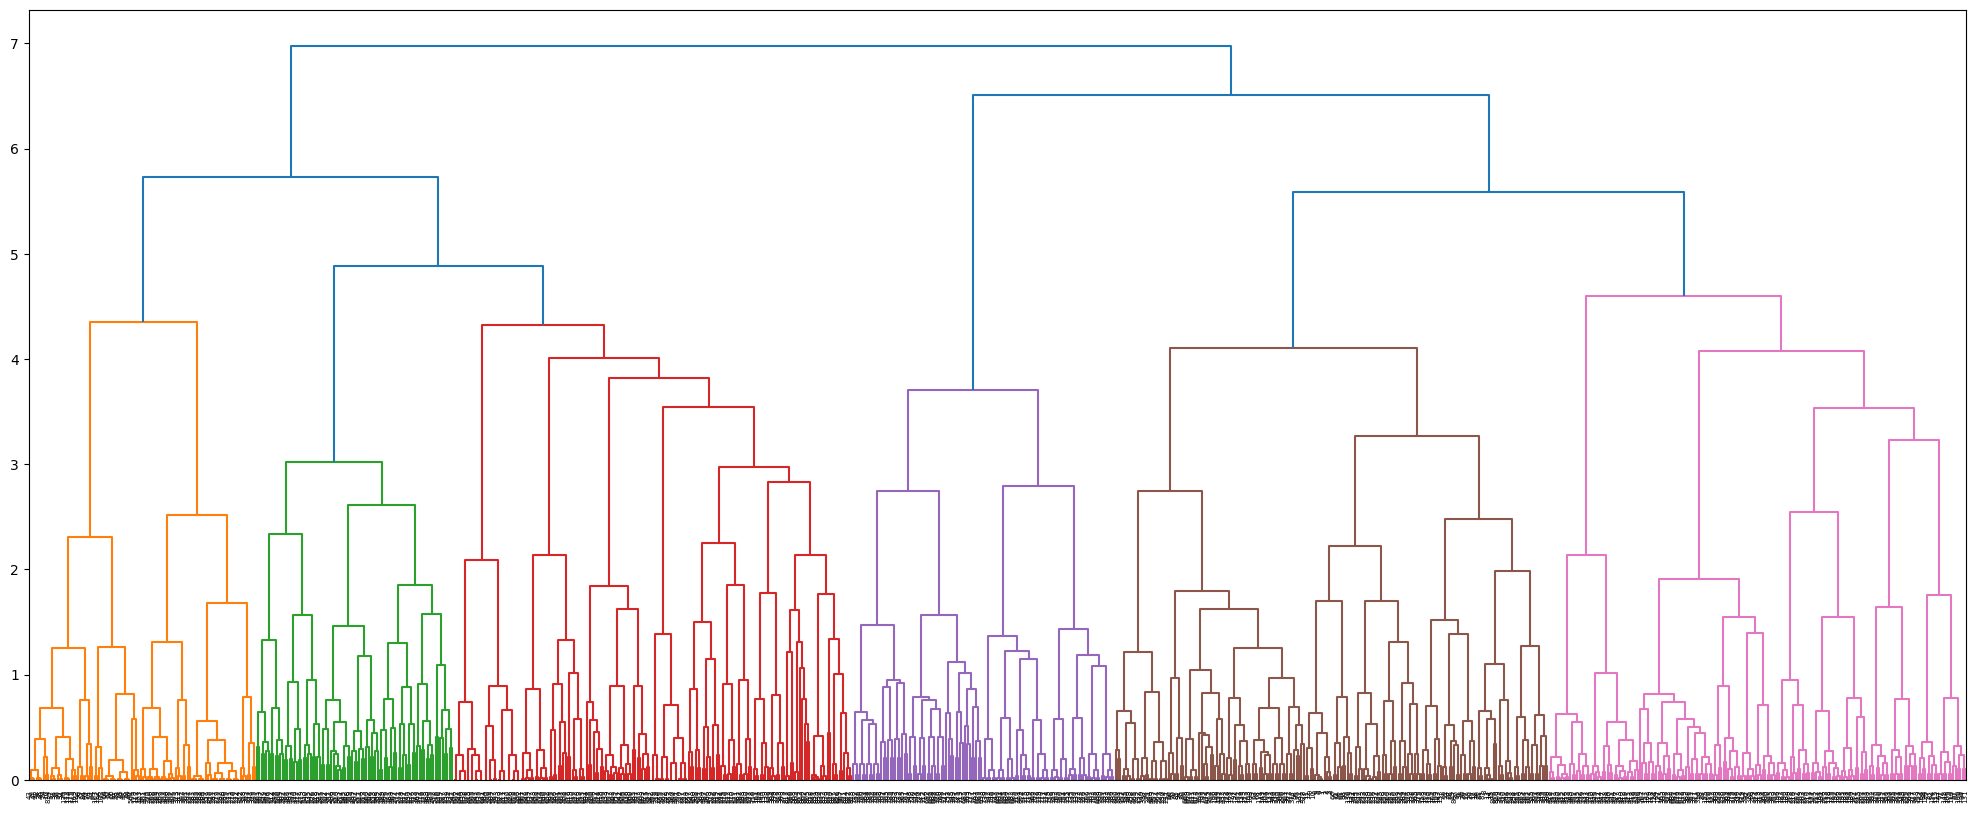

In [11]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_matrix)
plt.show()

In [12]:
n_clusters = 6
cluster_feature_dict = defaultdict(set)

In [13]:
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

In [14]:
for i in range(clusters.shape[0]):
    cluster_feature_dict[clusters[i]].add(col_names[i])

In [57]:
print(cluster_feature_dict)

defaultdict(<class 'set'>, {np.int32(5): {'X247', 'X487', 'X11', 'X163', 'X107', 'X186', 'X266', 'X15', 'X486', 'X358', 'X252', 'X357', 'X460', 'X274', 'X257', 'X239', 'X259', 'X158', 'X87', 'X16', 'X322', 'X334', 'X57', 'X340', 'X354', 'X461', 'X135', 'X155', 'X857', 'X145', 'X255', 'X99', 'X269', 'X115', 'X249', 'X304', 'X418', 'X262', 'X328', 'X6', 'X263', 'X77', 'X13', 'X324', 'X275', 'X23', 'X351', 'X10', 'X278', 'X21', 'X63', 'X363', 'X67', 'X273', 'X279', 'X28', 'X258', 'X261', 'X310', 'X396', 'X390', 'X20', 'X248', 'X360', 'X157', 'X105', 'X97', 'X2', 'X73', 'X143', 'X71', 'X177', 'X165', 'X848', 'X81', 'X720', 'X1', 'X271', 'X723', 'X318', 'X860', 'X101', 'X159', 'X254', 'X724', 'X406', 'X24', 'X59', 'X149', 'X412', 'X12', 'X22', 'X129', 'X31', 'X721', 'X27', 'X411', 'X123', 'X238', 'X276', 'X14', 'X29', 'X111', 'X346', 'X846', 'X103', 'X147', 'X7', 'X18', 'X312', 'X251', 'X722', 'X402', 'X93', 'X277', 'X256', 'X141', 'X394', 'X348', 'X849', 'X267', 'X171', 'X91', 'X26', 'X493

# SHAP with XGBoost

In [7]:
import xgboost
import shap

c:\Users\armin\Documents\GitHub\kaggle-crypto-market-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=5).fit(x_data, y_data)

x_data_sample = shap.utils.sample(x_data, 1000)

explainer_xgb = shap.Explainer(model_xgb, x_data_sample)
shap_values_xgb = explainer_xgb(x_data)

100%|===================| 525845/525887 [265:29<00:01]         

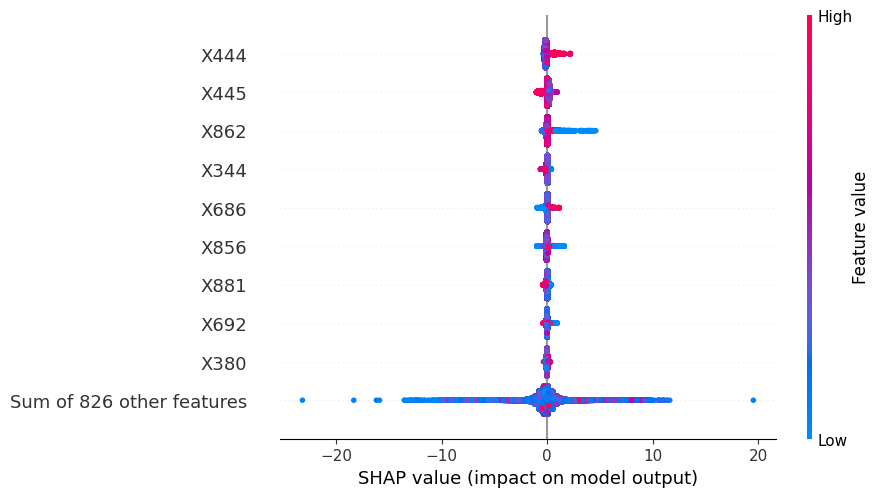

In [11]:
shap.plots.beeswarm(shap_values_xgb)

In [ ]:
import h5py

with h5py.File('shap_values_xgb.h5', 'w') as f:
    f.create_dataset('shap_values', data=shap_values_xgb)

In [ ]:
with h5py.File('shap_values_xgb.h5', 'r') as f:
    loaded_arr = f['shap_values'][:]